### Nutri-score Project - Decision Modeling - Master BDMA 2025/2026

**Notebook 4: Machine Learning Models**

This notebook explores a data-driven approach to food classification, using Supervised Machine Learning models to predict a product's category based on its nutritional composition and environmental score.

**Objectives:**

1. **Data Preparation:** Preprocess the food database, handling feature selection and target variable encoding.
2. **Model Training:** Train multiple classification algorithms, including:
    *   Random Forest
    *   Gradient Boosting
    *   Support Vector Machines (SVM)
    *   K-Nearest Neighbors (KNN)
    *   Logistic Regression
3. **Evaluation:** Assess model performance using 5-fold stratified cross-validation and metrics such as accuracy, precision, recall, and confusion matrices.
4. **Feature Analysis:** Investigate which attributes (e.g., sugar, protein, Green-Score) most strongly influence the automated classification.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import model_utils
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load and validate database
df = model_utils.load_food_database('data/food_database.xlsx')
model_utils.validate_database(df)

Database loaded: 353 products

=== DATABASE VALIDATION ===
Total products: 353
✓ Database size requirement met

Nutri-Score Distribution:
  ✓ Class A: 71 (20.11%)
  ✓ Class B: 70 (19.83%)
  ✓ Class C: 84 (23.8%)
  ✓ Class D: 59 (16.71%)
  ✓ Class E: 69 (19.55%)

Green-Score Distribution:
  ✓ Class A: 92 (26.06%)
  ✓ Class B: 102 (28.9%)
  ✓ Class C: 56 (15.86%)
  ✓ Class D: 49 (13.88%)
  ✓ Class E: 54 (15.3%)


In [4]:
print("\n" + "=" * 80)
print("STEP 2: DEFINING FEATURES AND TARGET VARIABLE")
print("=" * 80)

# Define the target column (the Nutri-Score label we want to predict)
target_col = 'nutri_score_label'

if target_col not in df.columns:
    print(f"✗ Error: Column '{target_col}' not found in the dataset")
    exit()

# Define feature columns (nutritional components used for prediction)
feature_cols = [
    'energy_100g',           # Energy content (to minimize)
    'saturated_fat_100g',    # Saturated fats (to minimize)
    'sugars_100g',           # Sugar content (to minimize)
    'salt_100g',             # Salt content (to minimize)
    'proteins_100g',         # Protein content (to maximize)
    'fiber_100g',            # Fiber content (to maximize)
    'fvl_percent',           # Fruits/vegetables/legumes percentage (to maximize)
    'green_score_value'      # Green-Score value (to maximize)
]

print(f"Target variable: {target_col}")
print(f"Features: {', '.join(feature_cols)}")

# Prepare features (X) and target (y)
# Convert to numeric and fill missing values with 0
X = df[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
y = df[target_col]

print(f"\nTarget distribution:")
print(y.value_counts().sort_index())
print(f"\nFeature statistics:")
print(X.describe())


STEP 2: DEFINING FEATURES AND TARGET VARIABLE
Target variable: nutri_score_label
Features: energy_100g, saturated_fat_100g, sugars_100g, salt_100g, proteins_100g, fiber_100g, fvl_percent, green_score_value

Target distribution:
nutri_score_label
A    71
B    70
C    84
D    59
E    69
Name: count, dtype: int64

Feature statistics:
       energy_100g  saturated_fat_100g  sugars_100g   salt_100g  \
count   353.000000          353.000000   353.000000  353.000000   
mean   1088.728895            2.713406    13.708858    0.881578   
std     670.742830            5.678151    21.173690    1.633011   
min      86.000000            0.000000     0.000000    0.000000   
25%     463.000000            0.235000     1.200000    0.030000   
50%    1024.000000            0.800000     3.400000    0.650000   
75%    1525.000000            2.400000    15.100000    1.080000   
max    3033.000000           34.000000    98.500000   17.200000   

       proteins_100g  fiber_100g  fvl_percent  green_score_val

In [5]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, 
                                           min_samples_leaf=2, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'Support Vector Machine': SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski'),
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0, max_iter=500, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
}

# 5-fold stratified CV (each fold ~70 train / ~70 test)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("Cross-Validation Results (5-Fold Stratified)")
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    results[name] = {'cv_scores': cv_scores, 'mean_accuracy': cv_scores.mean(), 'std_accuracy': cv_scores.std()}
    print(f"{name}: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Best model
best_name = max(results, key=lambda k: results[k]['mean_accuracy'])
print(f"\nBest: {best_name} ({results[best_name]['mean_accuracy']:.3f})")

Cross-Validation Results (5-Fold Stratified)
Random Forest: 0.728 (+/- 0.083)
Gradient Boosting: 0.748 (+/- 0.076)
Support Vector Machine: 0.391 (+/- 0.043)
K-Nearest Neighbors: 0.448 (+/- 0.092)
Logistic Regression: 0.595 (+/- 0.090)
Decision Tree: 0.646 (+/- 0.094)

Best: Gradient Boosting (0.748)


5-FOLD CV RESULTS FOR ALL MODELS

Random Forest:
  Fold 1: 73.2%
  Fold 2: 67.6%
  Fold 3: 77.5%
  Fold 4: 77.1%
  Fold 5: 68.6%
  → Mean ± 2×Std: 72.8% ± 8.3%

Gradient Boosting:
  Fold 1: 76.1%
  Fold 2: 67.6%
  Fold 3: 78.9%
  Fold 4: 75.7%
  Fold 5: 75.7%
  → Mean ± 2×Std: 74.8% ± 7.6%

Support Vector Machine:
  Fold 1: 39.4%
  Fold 2: 36.6%
  Fold 3: 36.6%
  Fold 4: 41.4%
  Fold 5: 41.4%
  → Mean ± 2×Std: 39.1% ± 4.3%

K-Nearest Neighbors:
  Fold 1: 42.3%
  Fold 2: 46.5%
  Fold 3: 39.4%
  Fold 4: 52.9%
  Fold 5: 42.9%
  → Mean ± 2×Std: 44.8% ± 9.2%

Logistic Regression:
  Fold 1: 57.7%
  Fold 2: 60.6%
  Fold 3: 52.1%
  Fold 4: 65.7%
  Fold 5: 61.4%
  → Mean ± 2×Std: 59.5% ± 9.0%

Decision Tree:
  Fold 1: 67.6%
  Fold 2: 66.2%
  Fold 3: 69.0%
  Fold 4: 64.3%
  Fold 5: 55.7%
  → Mean ± 2×Std: 64.6% ± 9.4%

FOLD 5 CONFUSION MATRICES (INDIVIDUAL PLOTS)

Generating Random Forest Fold 5 matrix...


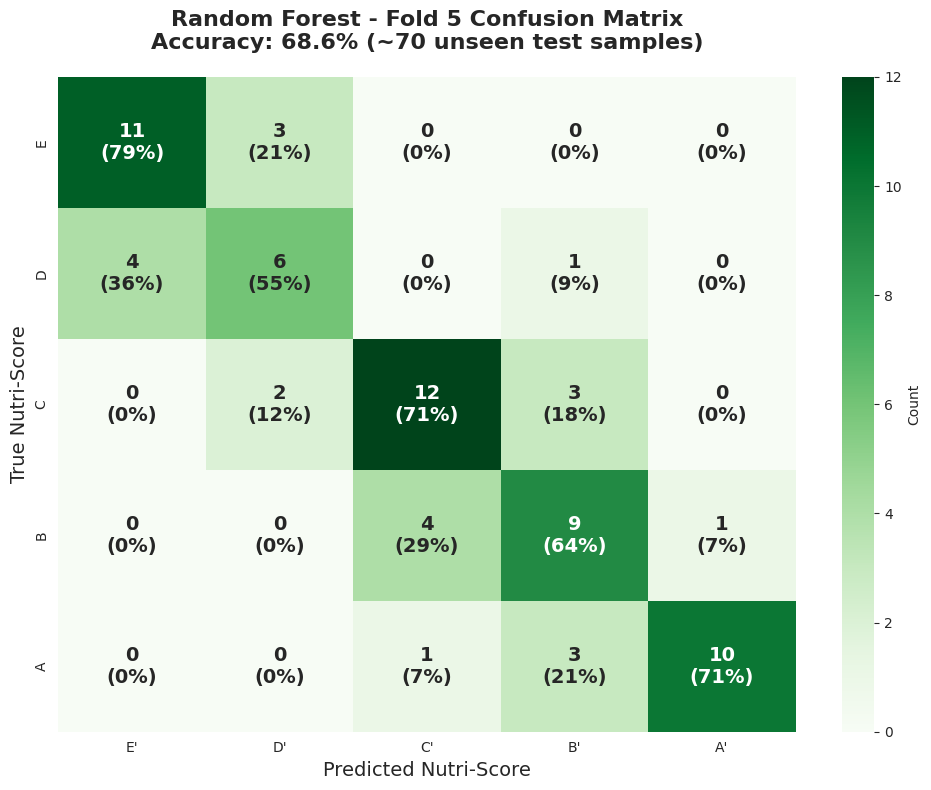


Generating Gradient Boosting Fold 5 matrix...


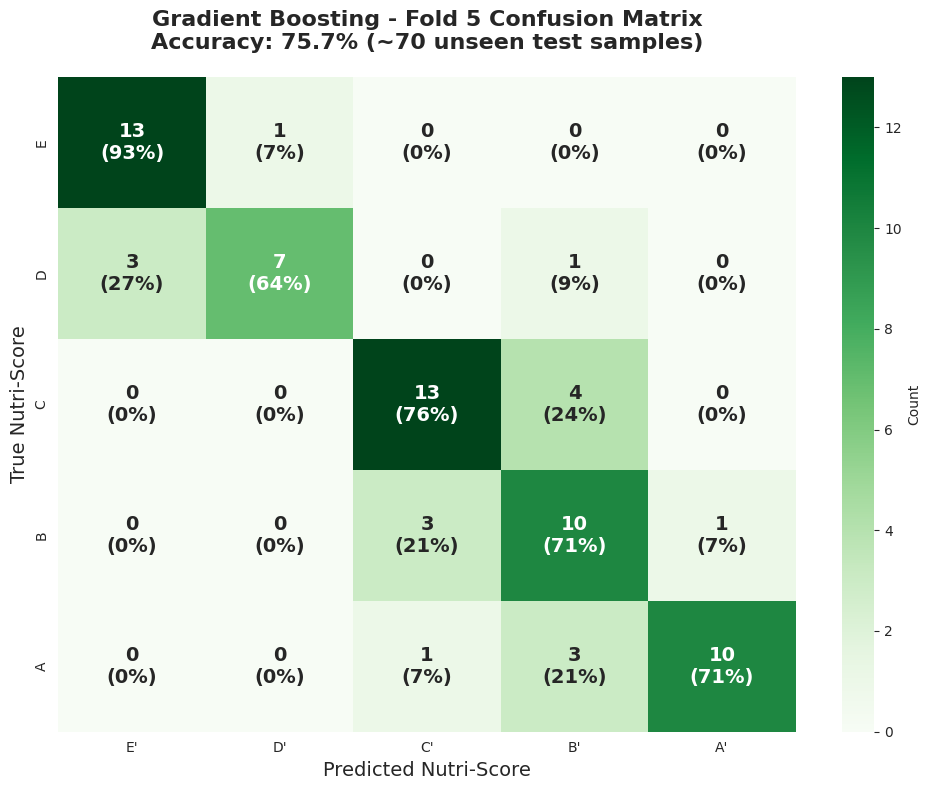


Generating Support Vector Machine Fold 5 matrix...


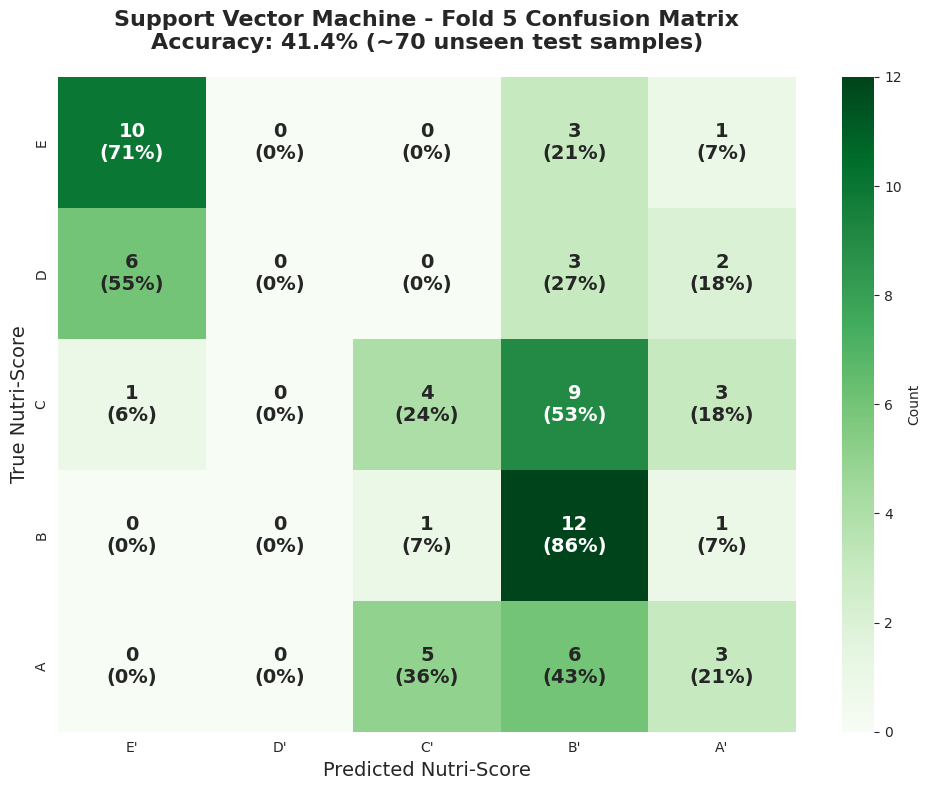


Generating K-Nearest Neighbors Fold 5 matrix...


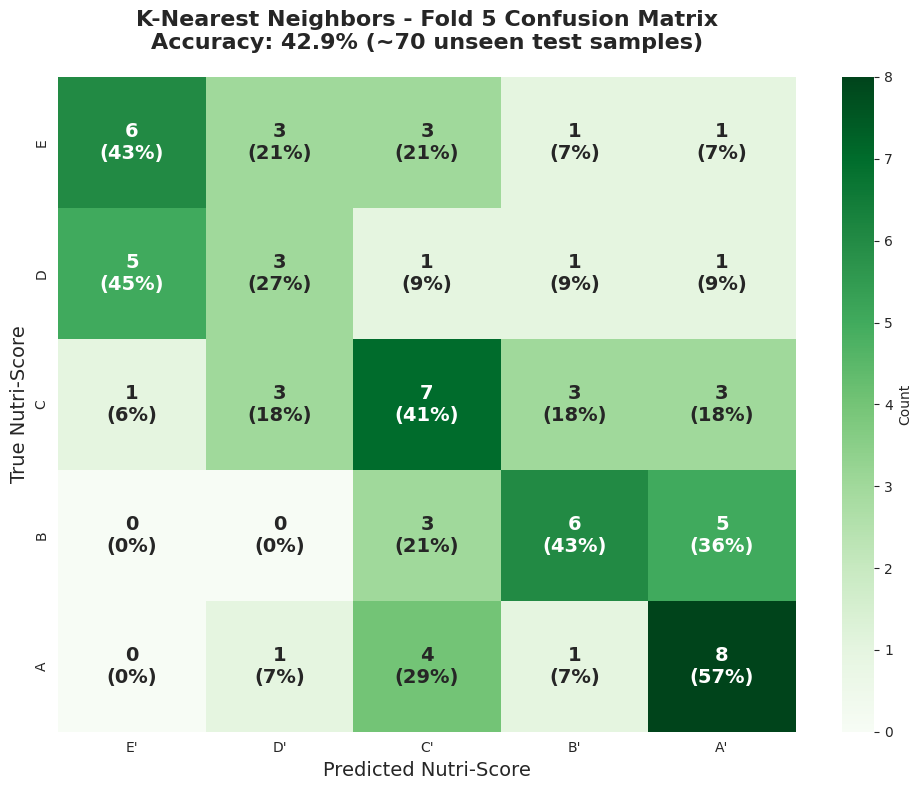


Generating Logistic Regression Fold 5 matrix...


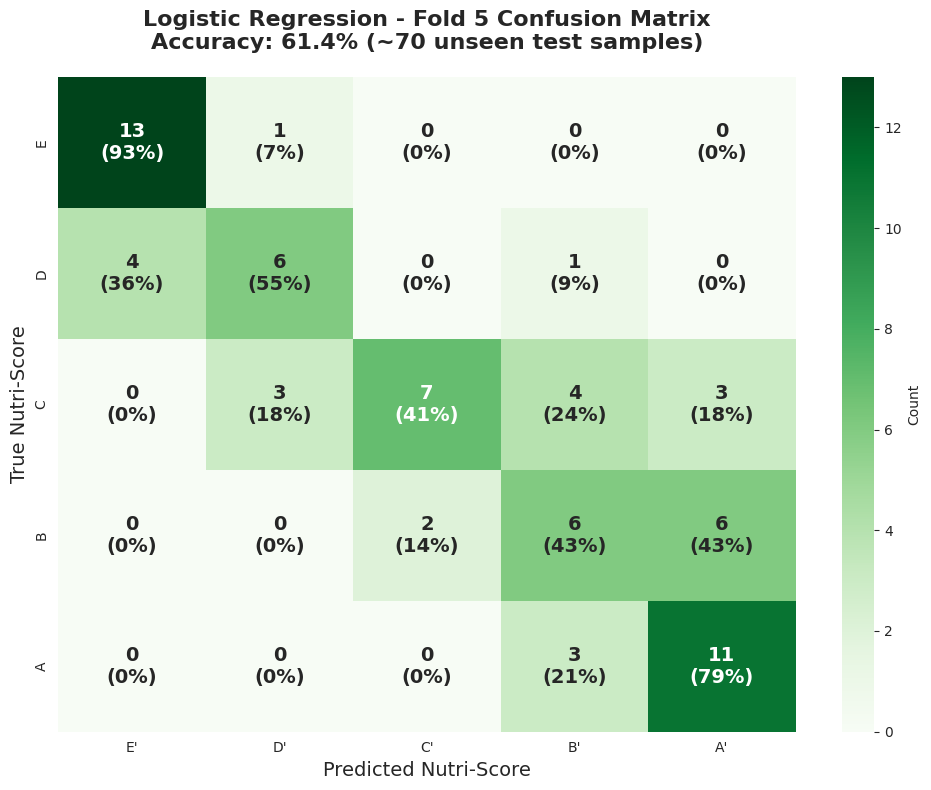


Generating Decision Tree Fold 5 matrix...


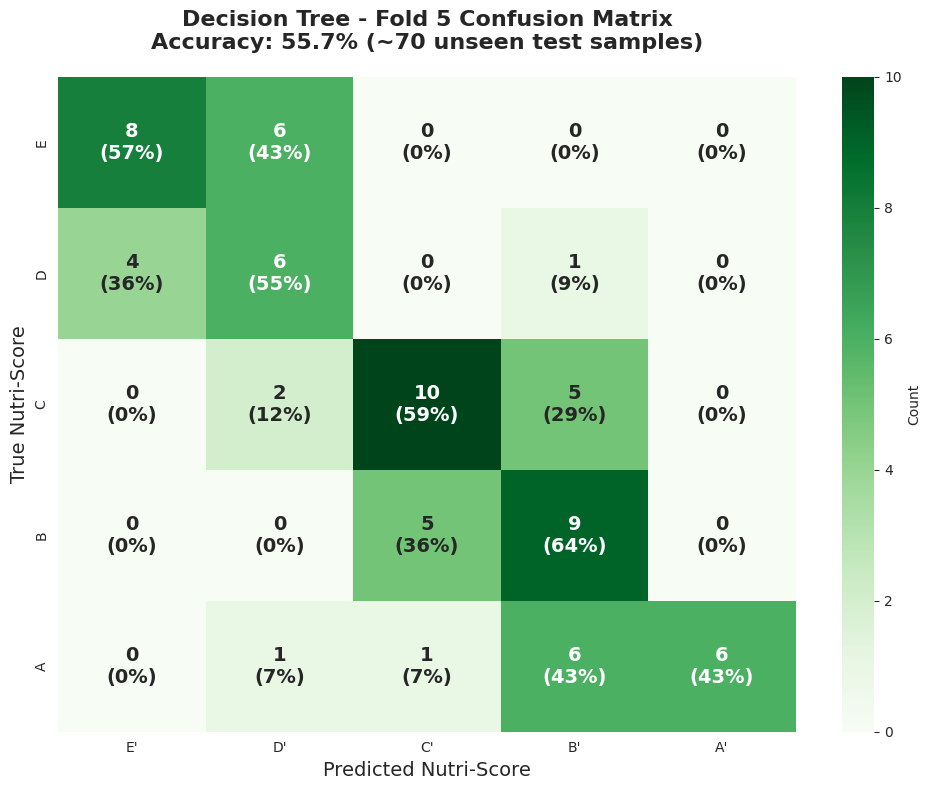

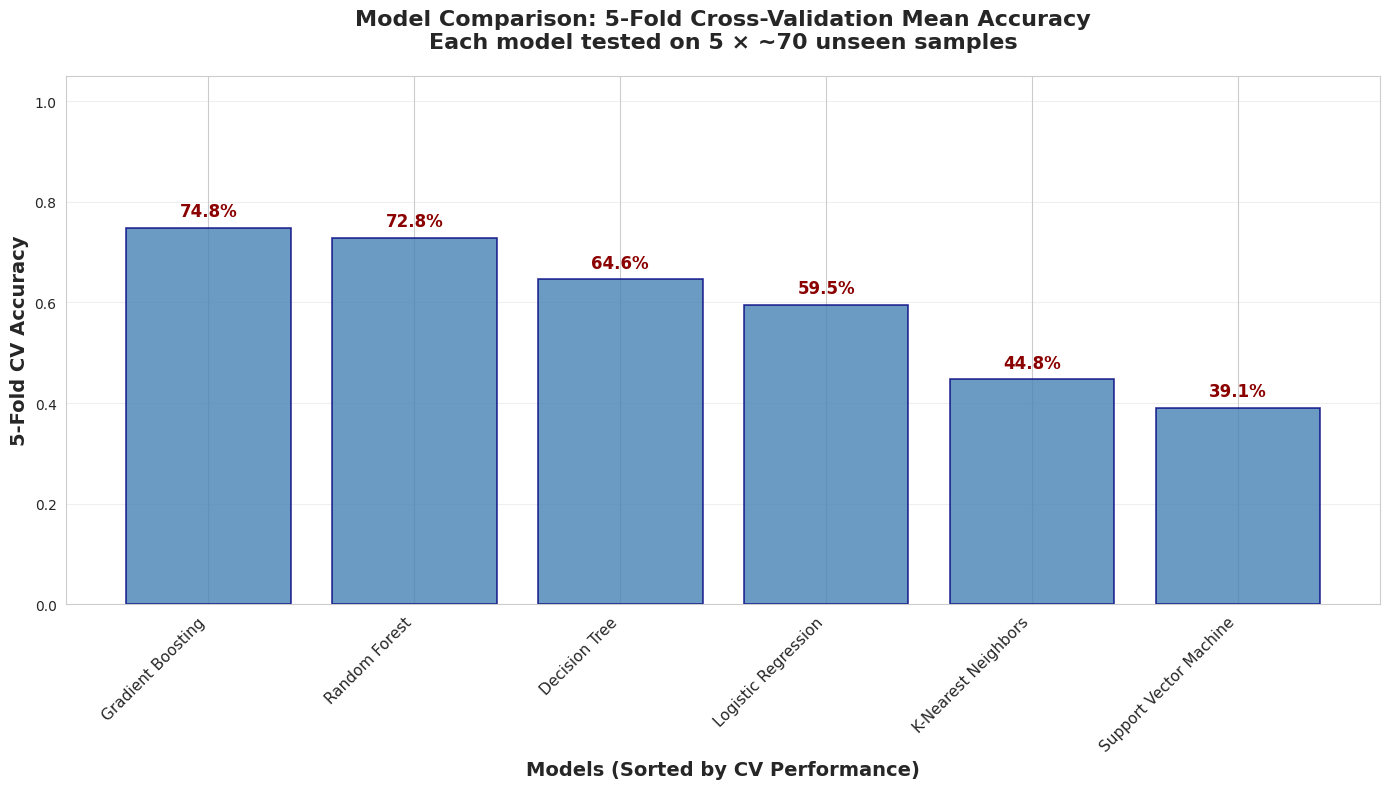


5-FOLD CV SUMMARY (Sorted by Mean Accuracy)
                 Model CV_Mean CV_Std Fold5
     Gradient Boosting   74.8%   3.8% 75.7%
         Random Forest   72.8%   4.1% 68.6%
         Decision Tree   64.6%   4.7% 55.7%
   Logistic Regression   59.5%   4.5% 61.4%
   K-Nearest Neighbors   44.8%   4.6% 42.9%
Support Vector Machine   39.1%   2.2% 41.4%


In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Your 6 models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, 
                                           min_samples_leaf=2, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'Support Vector Machine': SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski'),
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0, max_iter=500, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
labels = ['E', 'D', 'C', 'B', 'A']

# 1. COLLECT ALL FOLD ACCURACIES FOR ALL MODELS
all_fold_results = {}
print("5-FOLD CV RESULTS FOR ALL MODELS")
print("="*80)

for name, model_class in models.items():
    fold_accuracies = []
    print(f"\n{name}:")
    
    for fold_num, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        model = model_class
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)
        
        print(f"  Fold {fold_num+1}: {accuracy:.1%}")
    
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    all_fold_results[name] = {
        'fold_accuracies': fold_accuracies,
        'mean': mean_acc,
        'std': std_acc
    }
    print(f"  → Mean ± 2×Std: {mean_acc:.1%} ± {std_acc*2*100:.1f}%")

# 2. SEPARATE CONFUSION MATRICES FOR FOLD 5 (ONE PER MODEL)
print("\n" + "="*80)
print("FOLD 5 CONFUSION MATRICES (INDIVIDUAL PLOTS)")
print("="*80)

fold5_splits = list(cv.split(X, y))[4]
train_idx, test_idx = fold5_splits
X_train5, X_test5 = X.iloc[train_idx], X.iloc[test_idx]
y_train5, y_test5 = y.iloc[train_idx], y.iloc[test_idx]

fold5_accuracies = {}
for name, model_class in models.items():
    print(f"\nGenerating {name} Fold 5 matrix...")
    
    model = model_class
    model.fit(X_train5, y_train5)
    y_pred5 = model.predict(X_test5)
    accuracy5 = accuracy_score(y_test5, y_pred5)
    fold5_accuracies[name] = accuracy5
    
    # Confusion matrix
    cm = confusion_matrix(y_test5, y_pred5, labels=labels)
    percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    annot_labels = np.asarray([[f'{int(c)}\n({p:.0f}%)' for c, p in zip(row, perc_row)] 
                              for row, perc_row in zip(cm, percentages)])
    
    # SEPARATE plot for each model
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Greens', 
                xticklabels=['E\'','D\'','C\'','B\'','A\''], 
                yticklabels=labels,
                cbar_kws={'label': 'Count'},
                annot_kws={"size": 14, "weight": "bold"})
    
    plt.title(f'{name} - Fold 5 Confusion Matrix\nAccuracy: {accuracy5:.1%} (~70 unseen test samples)', 
              fontsize=16, weight='bold', pad=20)
    plt.xlabel('Predicted Nutri-Score', fontsize=14)
    plt.ylabel('True Nutri-Score', fontsize=14)
    plt.tight_layout()
    plt.show()

# 3. FIXED BAR PLOT: MEAN CV ACCURACY COMPARISON (SORTED)
plt.figure(figsize=(14, 8))

# Prepare data (sorted by mean accuracy)
model_names = list(all_fold_results.keys())
mean_accs = [all_fold_results[name]['mean'] for name in model_names]
std_accs = [all_fold_results[name]['std'] for name in model_names]

# Sort by mean accuracy (best to worst)
sorted_idx = np.argsort(mean_accs)[::-1]
sorted_names = [model_names[i] for i in sorted_idx]
sorted_means = [mean_accs[i] for i in sorted_idx]
sorted_stds = [std_accs[i] for i in sorted_idx]

x_pos = np.arange(len(sorted_names))
bars = plt.bar(x_pos, sorted_means, color='steelblue', alpha=0.8, 
               edgecolor='navy', linewidth=1.2)

# Add percentage labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.015,
             f'{height*100:.1f}%', ha='center', va='bottom', 
             fontsize=12, fontweight='bold', color='darkred')

plt.xlabel('Models (Sorted by CV Performance)', fontsize=14, fontweight='bold')
plt.ylabel('5-Fold CV Accuracy', fontsize=14, fontweight='bold')
plt.title('Model Comparison: 5-Fold Cross-Validation Mean Accuracy\nEach model tested on 5 × ~70 unseen samples', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(x_pos, sorted_names, rotation=45, ha='right', fontsize=11)
plt.ylim([0, 1.05])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. SUMMARY TABLE
print("\n" + "="*80)
print("5-FOLD CV SUMMARY (Sorted by Mean Accuracy)")
print("="*80)
summary_data = []
for i in sorted_idx:
    name = model_names[i]
    mean_acc = all_fold_results[name]['mean']
    std_acc = all_fold_results[name]['std']
    fold5_acc = fold5_accuracies[name]
    summary_data.append({
        'Model': name,
        'CV_Mean': f"{mean_acc*100:.1f}%",
        'CV_Std': f"{std_acc*100:.1f}%",
        'Fold5': f"{fold5_acc*100:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


In [11]:
# Retrain best model on all data
best_model = models[best_name]
best_model.fit(X, y)
y_pred = best_model.predict(X)

# Optional: 80/20 holdout for final report (or use cross_validate for full metrics)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
best_model.fit(X_train_final, y_train_final)
y_test_pred = best_model.predict(X_test_final)

print("Final Test Report:")
print(classification_report(y_test_final, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_final, y_test_pred))

Final Test Report:
              precision    recall  f1-score   support

           A       0.91      0.71      0.80        14
           B       0.60      0.86      0.71        14
           C       0.79      0.65      0.71        17
           D       0.60      0.75      0.67        12
           E       1.00      0.79      0.88        14

    accuracy                           0.75        71
   macro avg       0.78      0.75      0.75        71
weighted avg       0.78      0.75      0.75        71

Confusion Matrix:
[[10  4  0  0  0]
 [ 1 12  1  0  0]
 [ 0  3 11  3  0]
 [ 0  1  2  9  0]
 [ 0  0  0  3 11]]


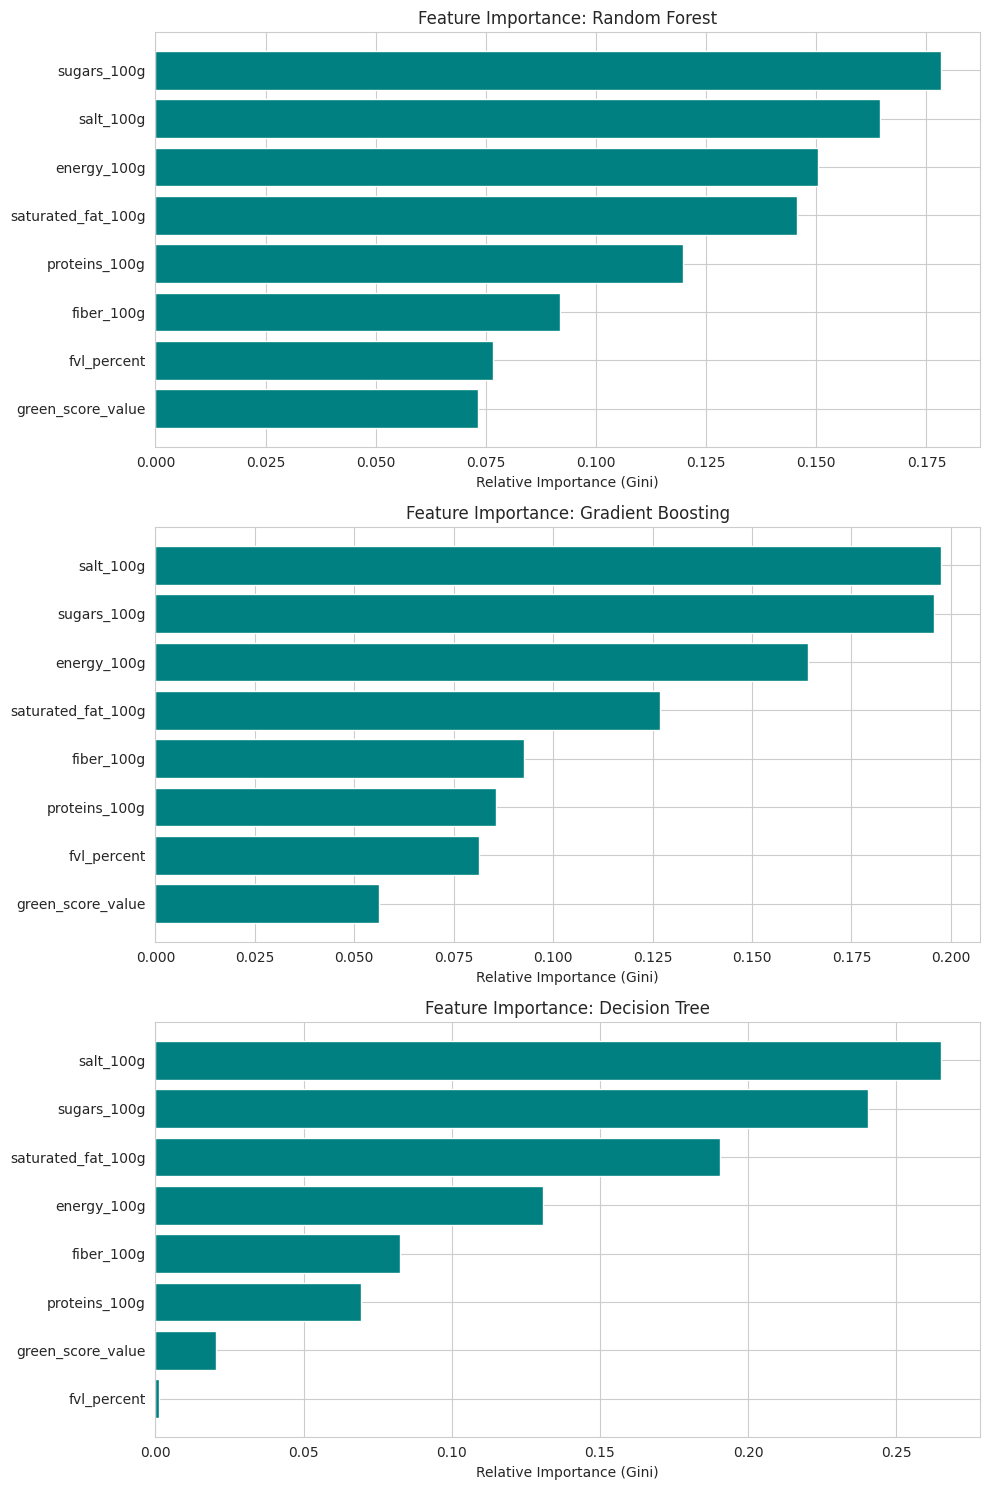

In [18]:
def plot_all_feature_importances(models_dict, feature_names):
    """
    Plots feature importances for models that support it (Trees/Forests).
    """
    tree_models = {k: v for k, v in models_dict.items() if hasattr(v, 'feature_importances_')}
    
    fig, axes = plt.subplots(len(tree_models), 1, figsize=(10, 5 * len(tree_models)))
    if len(tree_models) == 1: axes = [axes]
    
    for ax, (name, model) in zip(axes, tree_models.items()):
        importances = model.feature_importances_
        indices = np.argsort(importances)
        
        ax.barh(range(len(indices)), importances[indices], color='teal', align='center')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_title(f"Feature Importance: {name}")
        ax.set_xlabel("Relative Importance (Gini)")

    plt.tight_layout()
    plt.show()

# Use the 'models' dictionary defined in your notebook
feature_cols = ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 
                'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
plot_all_feature_importances(models, feature_cols)

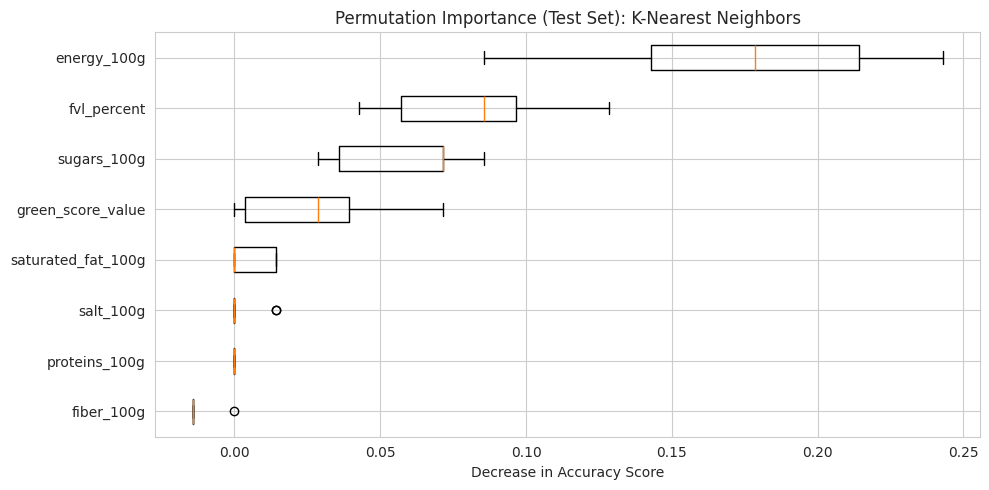

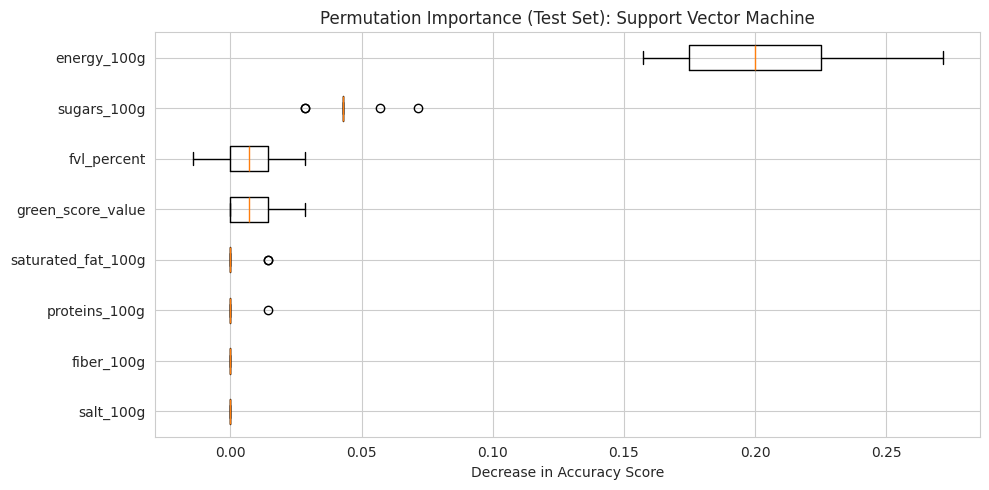

In [23]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X_val, y_val, feature_names, name):
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42)
    sorted_idx = result.importances_mean.argsort()

    plt.figure(figsize=(10, 5))
    plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
    plt.title(f"Permutation Importance (Test Set): {name}")
    plt.xlabel("Decrease in Accuracy Score")
    plt.tight_layout()
    plt.show()

plot_permutation_importance(models['K-Nearest Neighbors'], X_test, y_test, feature_cols, "K-Nearest Neighbors")
plot_permutation_importance(models['Support Vector Machine'], X_test, y_test, feature_cols, "Support Vector Machine")